In [1]:
import sys

sys.path.append("../")

from src.qaoa_scheduling import QAOACircuit, QAOAScheduler
import numpy as np

## C5 Example

In [2]:
def example_c5_circuit() -> QAOACircuit:
    """Create example QAOA circuit on 5 qubits."""
    n_qubits = 5
    gamma_gates = {
        (0, 1): 5.0,  # γ1
        (1, 2): 4.0,  # γ2
        (2, 3): 3.0,  # γ3
        (3, 4): 2.0,  # γ4
        (4, 0): 1.0,  # γ5
    }
    beta_time = 1.0  # Same mixer time for all qubits

    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=beta_time)

In [3]:
# Create circuit
circuit = example_c5_circuit()

# Create schedulera
scheduler = QAOAScheduler(circuit)

# Print LP model
print(scheduler.get_lp_model())

# Get schedule
result = scheduler.schedule_greedy()

Linear Programming Model for QAOA Gate Scheduling

Decision Variables:
x[g] = start time of gate g
y[g,g'] = 1 if gate g is before g', 0 otherwise
z = maximum completion time including mixer gates
T = large constant for ordering constraints

Objective:
Minimize z

Constraints:

1. Ordering constraints for gates sharing qubits:
   x_(0, 1) ≥ x_(3, 4) + 5.0 - T·y_(0, 1),(3, 4)
   x_(3, 4) ≥ x_(0, 1) + 5.0 - T·(1-y_(0, 1),(3, 4))
   x_(0, 1) ≥ x_(2, 3) + 5.0 - T·y_(0, 1),(2, 3)
   x_(2, 3) ≥ x_(0, 1) + 5.0 - T·(1-y_(0, 1),(2, 3))
   x_(1, 2) ≥ x_(4, 0) + 4.0 - T·y_(1, 2),(4, 0)
   x_(4, 0) ≥ x_(1, 2) + 4.0 - T·(1-y_(1, 2),(4, 0))
   x_(1, 2) ≥ x_(3, 4) + 4.0 - T·y_(1, 2),(3, 4)
   x_(3, 4) ≥ x_(1, 2) + 4.0 - T·(1-y_(1, 2),(3, 4))
   x_(2, 3) ≥ x_(0, 1) + 3.0 - T·y_(2, 3),(0, 1)
   x_(0, 1) ≥ x_(2, 3) + 3.0 - T·(1-y_(2, 3),(0, 1))
   x_(2, 3) ≥ x_(4, 0) + 3.0 - T·y_(2, 3),(4, 0)
   x_(4, 0) ≥ x_(2, 3) + 3.0 - T·(1-y_(2, 3),(4, 0))
   x_(3, 4) ≥ x_(0, 1) + 2.0 - T·y_(3, 4),(0, 1)
   x_(0, 1

In [4]:
# Print results
print("\nQAOA Gate Schedule:")
print(f"Total time before scheduling: {result.total_time_before}")
print(f"Total time after scheduling: {result.total_time_after}")
print(f"Time improvement: {result.improvement}")


QAOA Gate Schedule:
Total time before scheduling: 16.0
Total time after scheduling: 11.0
Time improvement: 5.0


In [5]:
print("\nCost gate layers:")
for i, layer in enumerate(result.cost_layers):
    print(f"\nLayer {i+1} (time = {layer.time}):")
    for gate in layer.gates:
        print(f"  Gate Q{gate[0]}-Q{gate[1]}: time = {circuit.gamma_gates[gate]}")

print(f"\nMixer layer (time = {result.mixer_layer.time}):")
print("  All qubits in parallel")


Cost gate layers:

Layer 1 (time = 5.0):
  Gate Q0-Q1: time = 5.0
  Gate Q2-Q3: time = 3.0

Layer 2 (time = 4.0):
  Gate Q1-Q2: time = 4.0
  Gate Q3-Q4: time = 2.0

Layer 3 (time = 1.0):
  Gate Q4-Q0: time = 1.0

Mixer layer (time = 1.0):
  All qubits in parallel


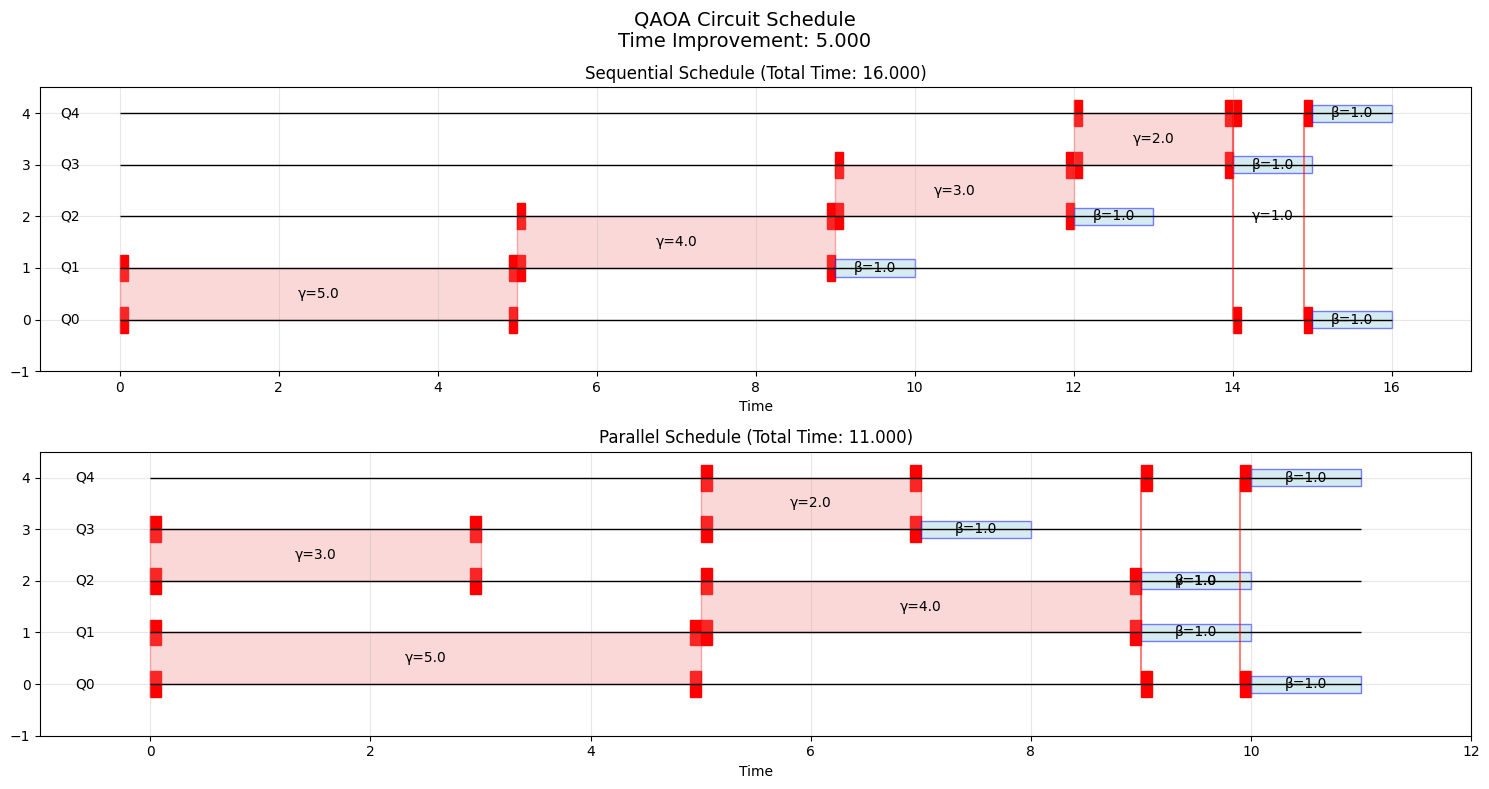

In [6]:
# Visualize schedule
scheduler.visualize_schedule_comparison(result)

## C7 Example

In [7]:
def example_c7_circuit() -> QAOACircuit:
    """Create example QAOA circuit on 7 qubits (C7 graph)."""
    n_qubits = 7
    gamma_gates = {
        (0, 1): 7.0,  # γ1
        (1, 2): 6.0,  # γ2
        (2, 3): 5.0,  # γ3
        (3, 4): 4.0,  # γ4
        (4, 5): 3.0,  # γ5
        (5, 6): 2.0,  # γ6
        (6, 0): 1.0,  # γ7
    }
    beta_time = 1.0  # Same mixer time for all qubits

    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=beta_time)

In [8]:
# Create circuit
circuit = example_c7_circuit()

# Create scheduler
scheduler = QAOAScheduler(circuit)

# Print LP model
print("Linear Programming Model:")
print("=" * 50)
print(scheduler.get_lp_model())

Linear Programming Model:
Linear Programming Model for QAOA Gate Scheduling

Decision Variables:
x[g] = start time of gate g
y[g,g'] = 1 if gate g is before g', 0 otherwise
z = maximum completion time including mixer gates
T = large constant for ordering constraints

Objective:
Minimize z

Constraints:

1. Ordering constraints for gates sharing qubits:
   x_(0, 1) ≥ x_(3, 4) + 7.0 - T·y_(0, 1),(3, 4)
   x_(3, 4) ≥ x_(0, 1) + 7.0 - T·(1-y_(0, 1),(3, 4))
   x_(0, 1) ≥ x_(2, 3) + 7.0 - T·y_(0, 1),(2, 3)
   x_(2, 3) ≥ x_(0, 1) + 7.0 - T·(1-y_(0, 1),(2, 3))
   x_(0, 1) ≥ x_(4, 5) + 7.0 - T·y_(0, 1),(4, 5)
   x_(4, 5) ≥ x_(0, 1) + 7.0 - T·(1-y_(0, 1),(4, 5))
   x_(0, 1) ≥ x_(5, 6) + 7.0 - T·y_(0, 1),(5, 6)
   x_(5, 6) ≥ x_(0, 1) + 7.0 - T·(1-y_(0, 1),(5, 6))
   x_(1, 2) ≥ x_(3, 4) + 6.0 - T·y_(1, 2),(3, 4)
   x_(3, 4) ≥ x_(1, 2) + 6.0 - T·(1-y_(1, 2),(3, 4))
   x_(1, 2) ≥ x_(4, 5) + 6.0 - T·y_(1, 2),(4, 5)
   x_(4, 5) ≥ x_(1, 2) + 6.0 - T·(1-y_(1, 2),(4, 5))
   x_(1, 2) ≥ x_(5, 6) + 6.0 - T·

In [9]:
# Get schedule
result = scheduler.schedule_greedy()

# Print results
print("\nQAOA Gate Schedule:")
print("=" * 50)
print(f"Total time before scheduling: {result.total_time_before}")
print(f"Total time after scheduling: {result.total_time_after}")
print(f"Time improvement: {result.improvement}")


QAOA Gate Schedule:
Total time before scheduling: 29.0
Total time after scheduling: 15.0
Time improvement: 14.0


In [10]:
print("\nCost gate layers:")
print("-" * 30)
for i, layer in enumerate(result.cost_layers):
    print(f"\nLayer {i+1} (time = {layer.time}):")
    for gate in layer.gates:
        print(f"  Gate Q{gate[0]}-Q{gate[1]}: time = {circuit.gamma_gates[gate]}")

print(f"\nMixer layer (time = {result.mixer_layer.time}):")
print("-" * 30)
print("  All qubits in parallel")


Cost gate layers:
------------------------------

Layer 1 (time = 7.0):
  Gate Q0-Q1: time = 7.0
  Gate Q2-Q3: time = 5.0
  Gate Q4-Q5: time = 3.0

Layer 2 (time = 6.0):
  Gate Q1-Q2: time = 6.0
  Gate Q3-Q4: time = 4.0
  Gate Q5-Q6: time = 2.0

Layer 3 (time = 1.0):
  Gate Q6-Q0: time = 1.0

Mixer layer (time = 1.0):
------------------------------
  All qubits in parallel


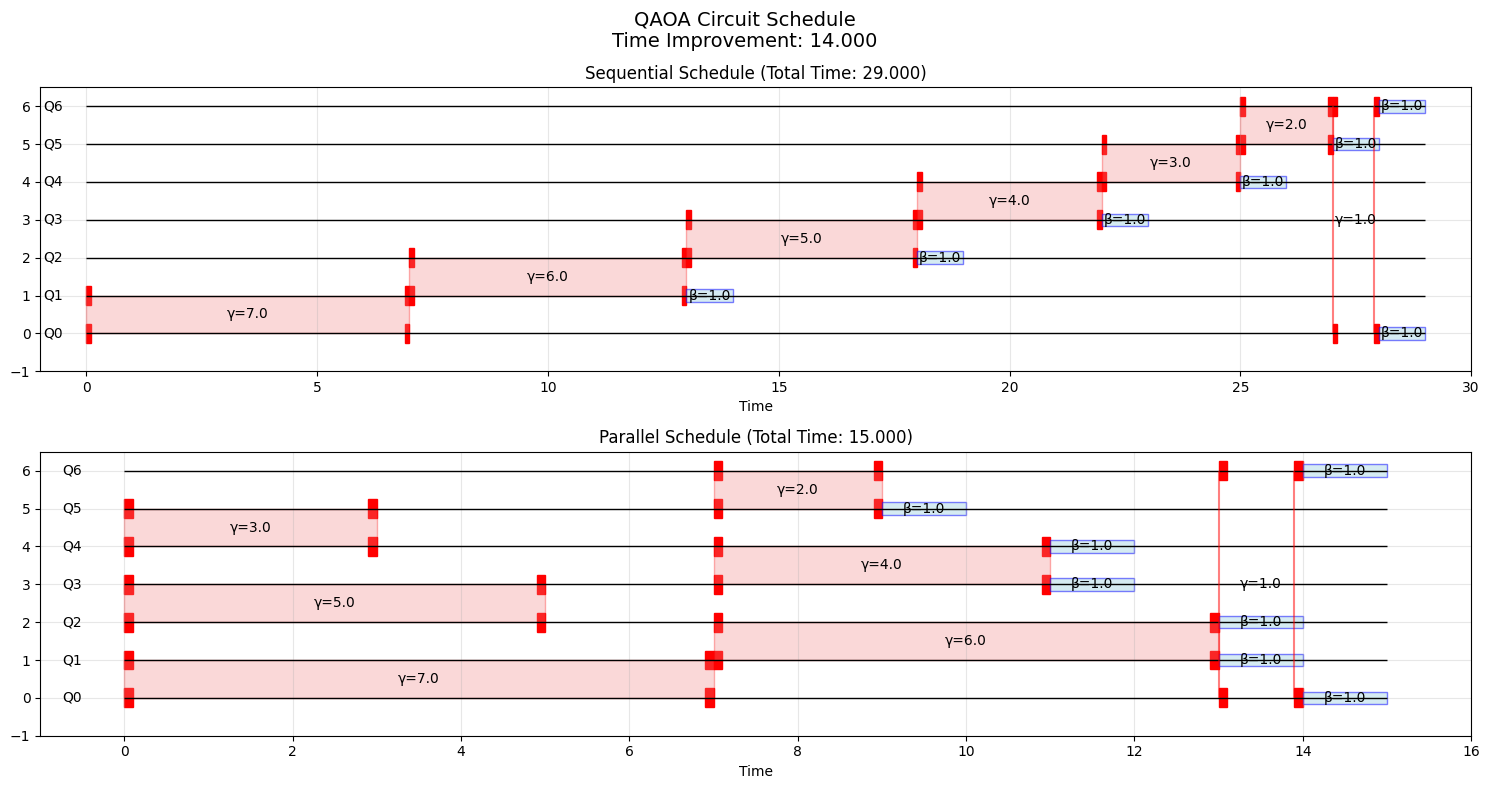

In [11]:
# Visualize schedule
scheduler.visualize_schedule_comparison(result)

## Circuits with Random Times

In [12]:
def create_random_circuit(
    n_qubits: int,
    gamma_min: float = 0,
    gamma_max: float = 2 * np.pi,
    beta_time: float = 1.0,
    seed=None,
) -> QAOACircuit:
    """Create a cycle graph QAOA circuit with random gamma gate times."""
    if seed is not None:
        np.random.seed(seed)

    # Create gamma gates with random times
    gamma_gates = {}
    for i in range(n_qubits):
        gamma_gates[(i, (i + 1) % n_qubits)] = np.round(
            np.random.uniform(gamma_min, gamma_max), 3
        )

    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=beta_time)


def run_example(circuit: QAOACircuit, instance_num: int):
    """Run and display results for one circuit instance."""
    print(f"\nInstance {instance_num}")
    print("=" * 50)

    # Print gate times
    print("Gate times:")
    for gate, time in circuit.gamma_gates.items():
        print(f"  γ(Q{gate[0]}-Q{gate[1]}): {time:.2f}")

    # Create scheduler and get result
    scheduler = QAOAScheduler(circuit)
    result = scheduler.schedule_greedy()

    # Print results
    print("\nScheduling results:")
    print(f"Total time before: {result.total_time_before:.2f}")
    print(f"Total time after: {result.total_time_after:.2f}")
    print(
        f"Time improvement: {result.improvement:.2f} ({result.improvement/result.total_time_before:.1%})"
    )

    print("\nScheduling layers:")
    for i, layer in enumerate(result.cost_layers):
        print(f"\nLayer {i+1} (time = {layer.time:.2f}):")
        for gate in layer.gates:
            print(
                f"  Gate Q{gate[0]}-Q{gate[1]}: time = {circuit.gamma_gates[gate]:.2f}"
            )

    print(f"\nMixer layer (time = {result.mixer_layer.time:.2f})")

    # Visualize
    scheduler.visualize_schedule_comparison(result)

    return result


def analyze_results(results, circuit_type: str):
    """Analyze results across all instances."""
    improvements = [r.improvement / r.total_time_before for r in results]
    n_layers = [len(r.cost_layers) for r in results]

    print(f"\nAnalysis for {circuit_type}:")
    print("=" * 50)
    print(f"Average improvement: {np.mean(improvements):.1%}")
    print(f"Best improvement: {max(improvements):.1%}")
    print(f"Worst improvement: {min(improvements):.1%}")
    print(f"Average number of layers: {np.mean(n_layers):.1f}")
    print(f"Layer distribution: {np.unique(n_layers, return_counts=True)}")


C5 Examples

C5 Instance 1
------------------------------

Instance 1
Gate times:
  γ(Q0-Q1): 2.35
  γ(Q1-Q2): 5.97
  γ(Q2-Q3): 4.60
  γ(Q3-Q4): 3.76
  γ(Q4-Q0): 0.98

Scheduling results:
Total time before: 18.67
Total time after: 12.55
Time improvement: 6.11 (32.8%)

Scheduling layers:

Layer 1 (time = 5.97):
  Gate Q1-Q2: time = 5.97
  Gate Q3-Q4: time = 3.76

Layer 2 (time = 4.60):
  Gate Q2-Q3: time = 4.60
  Gate Q0-Q1: time = 2.35

Layer 3 (time = 0.98):
  Gate Q4-Q0: time = 0.98

Mixer layer (time = 1.00)


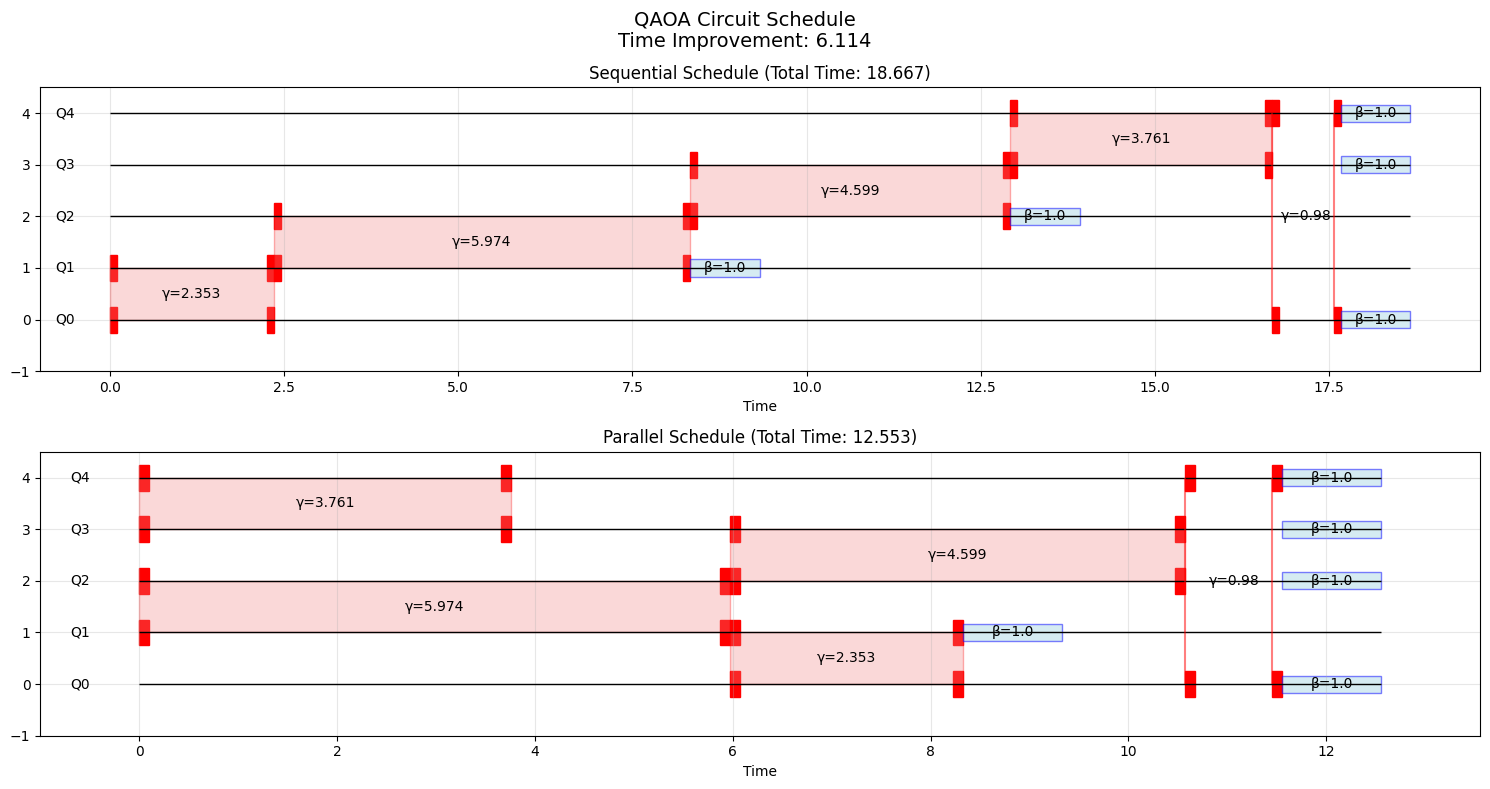


C5 Instance 2
------------------------------

Instance 2
Gate times:
  γ(Q0-Q1): 0.72
  γ(Q1-Q2): 3.83
  γ(Q2-Q3): 0.84
  γ(Q3-Q4): 1.51
  γ(Q4-Q0): 2.06

Scheduling results:
Total time before: 9.96
Total time after: 7.18
Time improvement: 2.78 (27.9%)

Scheduling layers:

Layer 1 (time = 3.83):
  Gate Q1-Q2: time = 3.83
  Gate Q4-Q0: time = 2.06

Layer 2 (time = 1.51):
  Gate Q3-Q4: time = 1.51
  Gate Q0-Q1: time = 0.72

Layer 3 (time = 0.84):
  Gate Q2-Q3: time = 0.84

Mixer layer (time = 1.00)


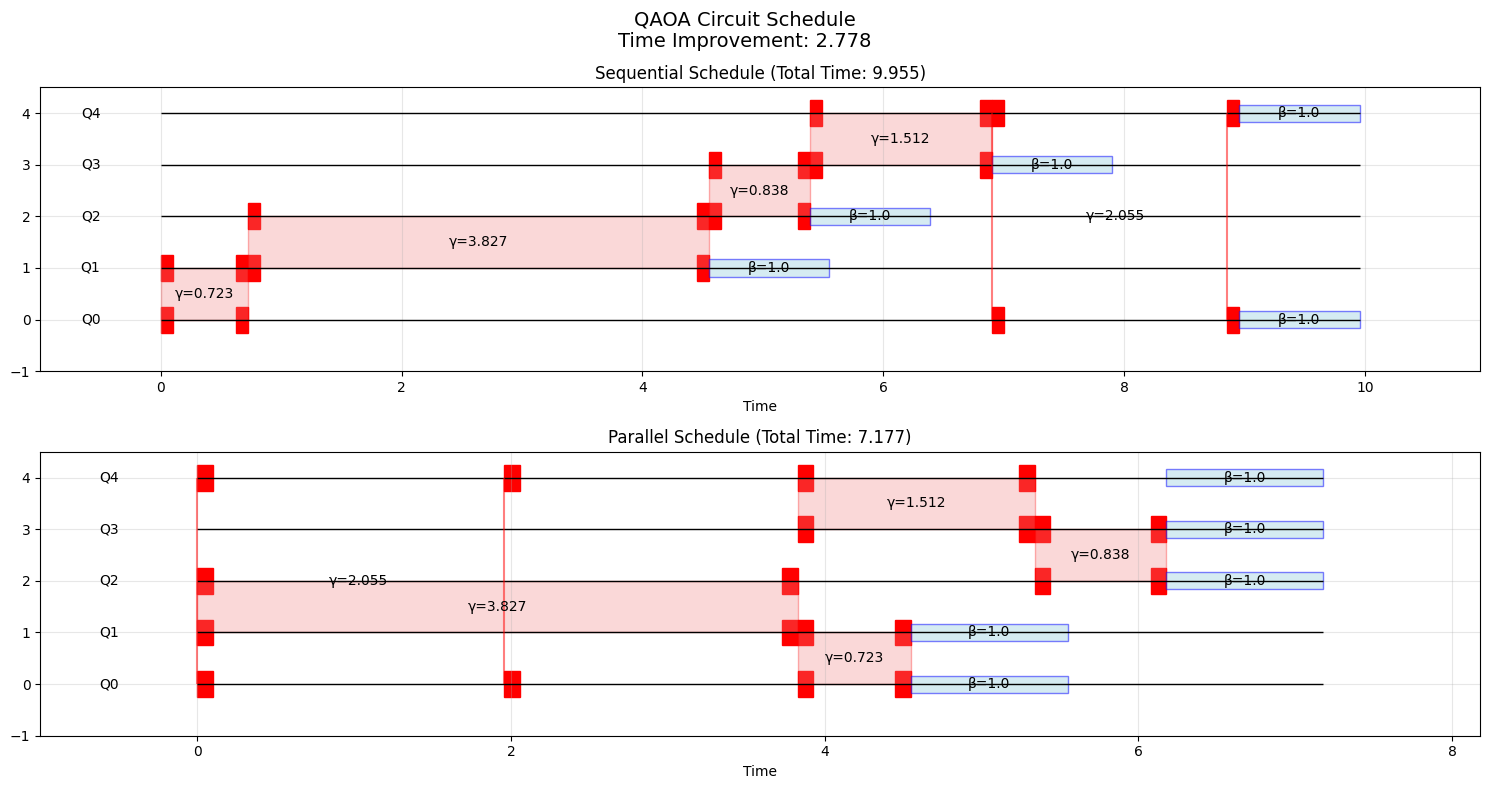


C5 Instance 3
------------------------------

Instance 3
Gate times:
  γ(Q0-Q1): 5.25
  γ(Q1-Q2): 0.66
  γ(Q2-Q3): 4.68
  γ(Q3-Q4): 2.27
  γ(Q4-Q0): 2.26

Scheduling results:
Total time before: 16.11
Total time after: 10.77
Time improvement: 5.34 (33.1%)

Scheduling layers:

Layer 1 (time = 5.25):
  Gate Q0-Q1: time = 5.25
  Gate Q2-Q3: time = 4.68

Layer 2 (time = 2.27):
  Gate Q3-Q4: time = 2.27
  Gate Q1-Q2: time = 0.66

Layer 3 (time = 2.26):
  Gate Q4-Q0: time = 2.26

Mixer layer (time = 1.00)


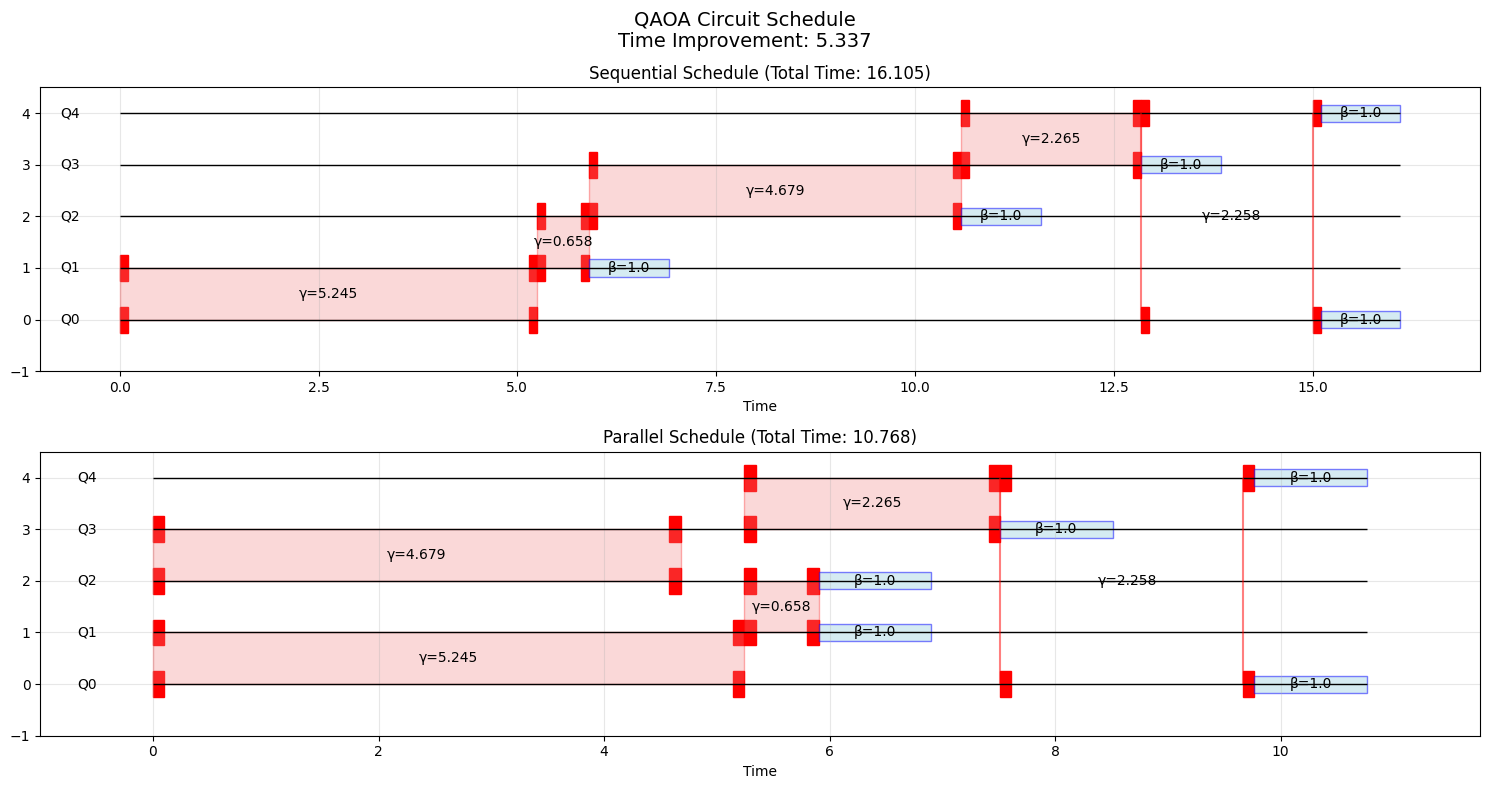


C5 Instance 4
------------------------------

Instance 4
Gate times:
  γ(Q0-Q1): 6.21
  γ(Q1-Q2): 3.45
  γ(Q2-Q3): 1.77
  γ(Q3-Q4): 0.49
  γ(Q4-Q0): 2.79

Scheduling results:
Total time before: 15.71
Total time after: 11.15
Time improvement: 4.56 (29.0%)

Scheduling layers:

Layer 1 (time = 6.21):
  Gate Q0-Q1: time = 6.21
  Gate Q2-Q3: time = 1.77

Layer 2 (time = 3.45):
  Gate Q1-Q2: time = 3.45
  Gate Q4-Q0: time = 2.79

Layer 3 (time = 0.49):
  Gate Q3-Q4: time = 0.49

Mixer layer (time = 1.00)


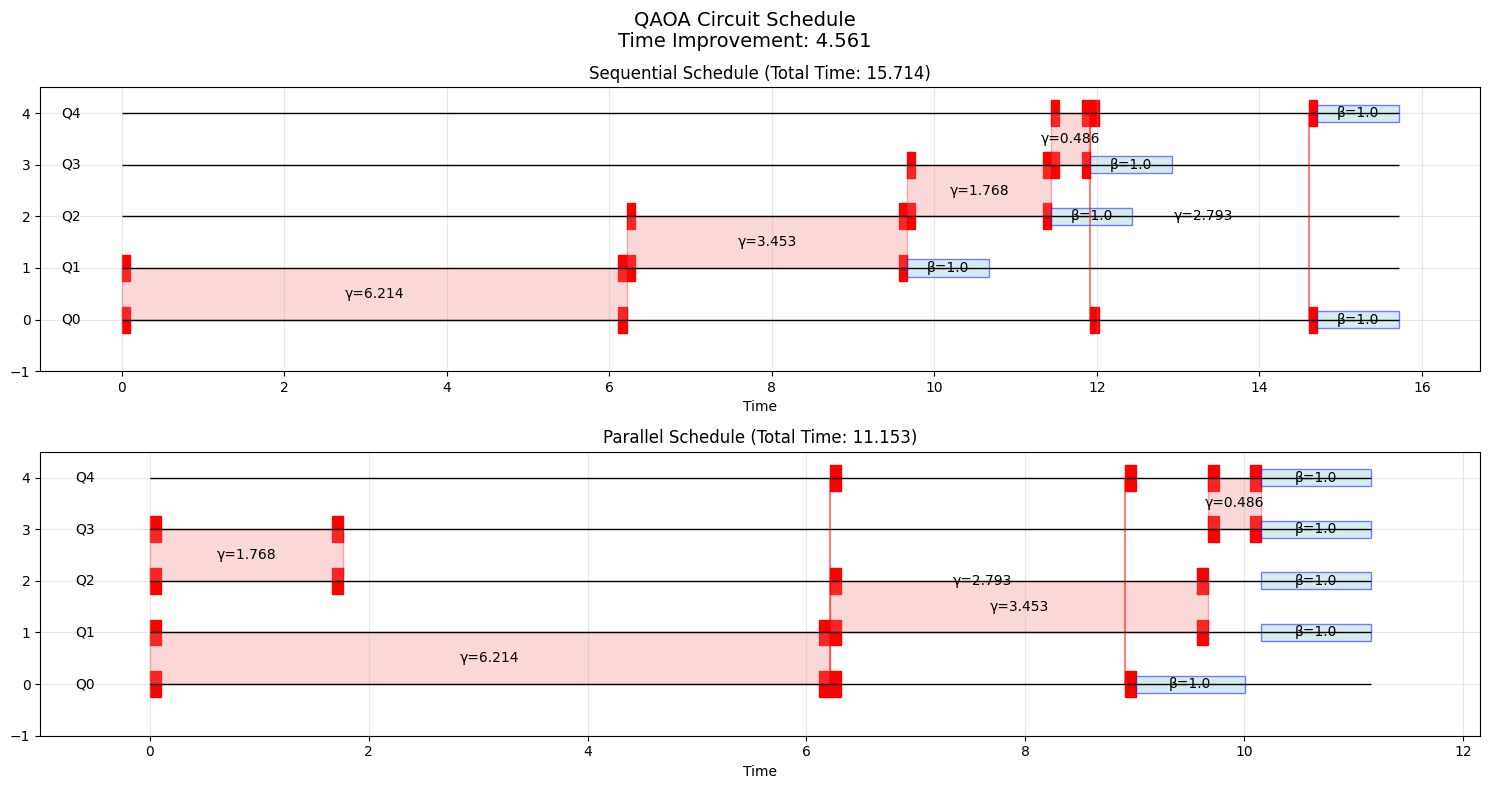


C5 Instance 5
------------------------------

Instance 5
Gate times:
  γ(Q0-Q1): 4.92
  γ(Q1-Q2): 3.99
  γ(Q2-Q3): 1.56
  γ(Q3-Q4): 4.76
  γ(Q4-Q0): 1.97

Scheduling results:
Total time before: 18.21
Total time after: 11.48
Time improvement: 6.73 (37.0%)

Scheduling layers:

Layer 1 (time = 4.92):
  Gate Q0-Q1: time = 4.92
  Gate Q3-Q4: time = 4.76

Layer 2 (time = 3.99):
  Gate Q1-Q2: time = 3.99
  Gate Q4-Q0: time = 1.97

Layer 3 (time = 1.56):
  Gate Q2-Q3: time = 1.56

Mixer layer (time = 1.00)


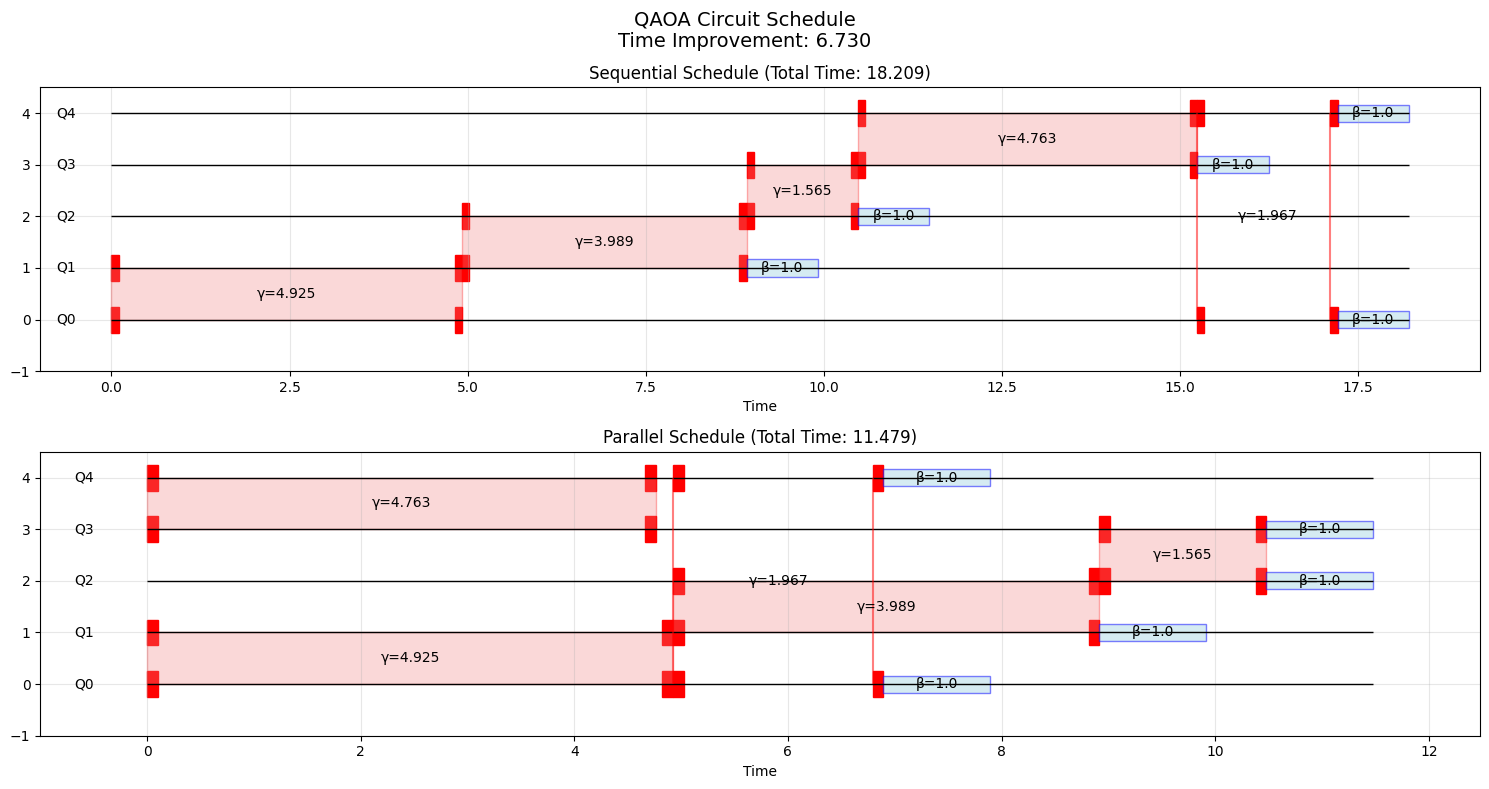


C7 Examples

C7 Instance 1
------------------------------

Instance 1
Gate times:
  γ(Q0-Q1): 0.71
  γ(Q1-Q2): 6.12
  γ(Q2-Q3): 4.58
  γ(Q3-Q4): 2.21
  γ(Q4-Q5): 4.45
  γ(Q5-Q6): 5.02
  γ(Q6-Q0): 4.06

Scheduling results:
Total time before: 28.15
Total time after: 12.41
Time improvement: 15.73 (55.9%)

Scheduling layers:

Layer 1 (time = 6.12):
  Gate Q1-Q2: time = 6.12
  Gate Q5-Q6: time = 5.02
  Gate Q3-Q4: time = 2.21

Layer 2 (time = 4.58):
  Gate Q2-Q3: time = 4.58
  Gate Q4-Q5: time = 4.45
  Gate Q6-Q0: time = 4.06

Layer 3 (time = 0.71):
  Gate Q0-Q1: time = 0.71

Mixer layer (time = 1.00)


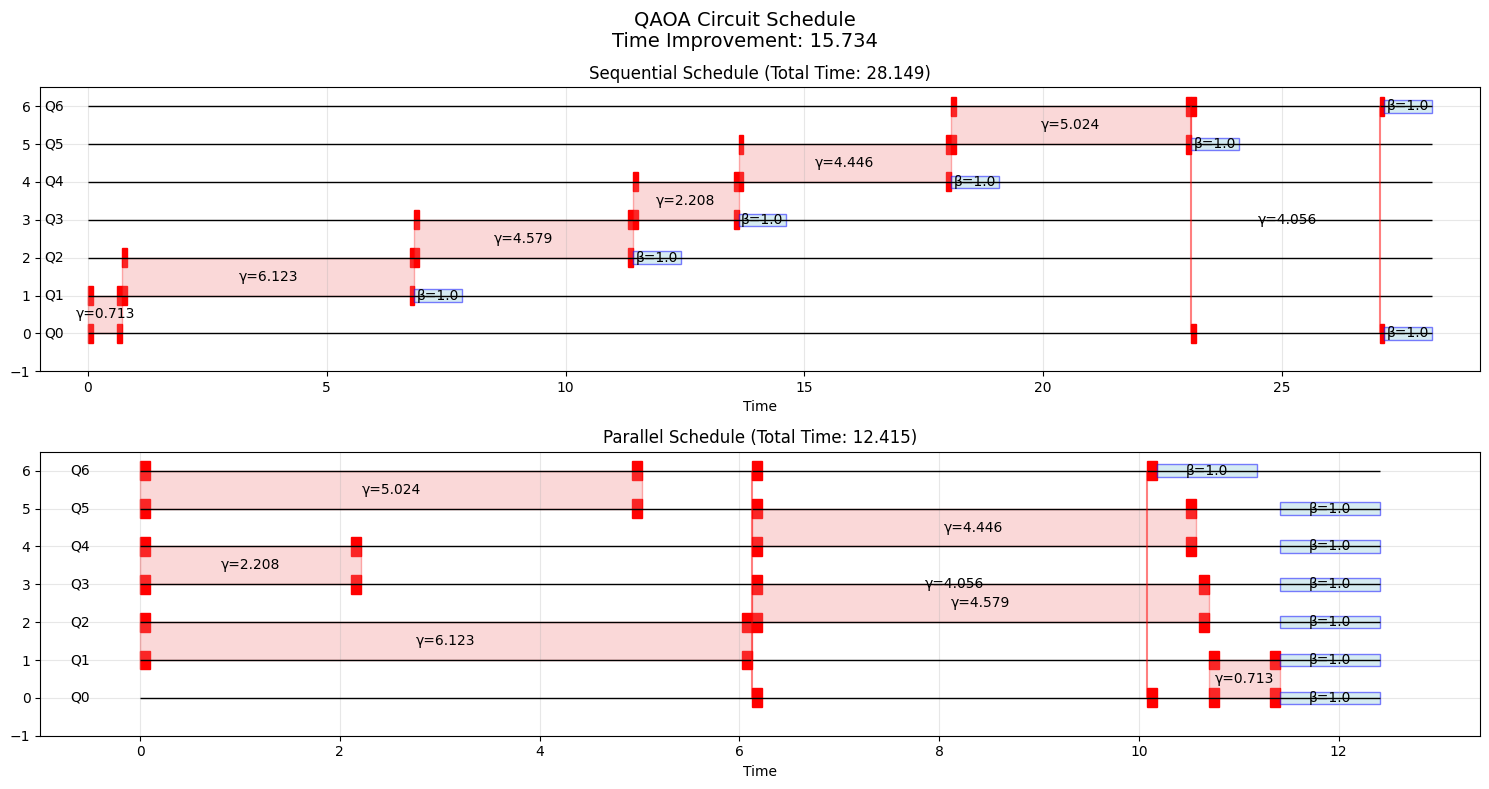


C7 Instance 2
------------------------------

Instance 2
Gate times:
  γ(Q0-Q1): 0.11
  γ(Q1-Q2): 5.60
  γ(Q2-Q3): 1.79
  γ(Q3-Q4): 1.88
  γ(Q4-Q5): 4.98
  γ(Q5-Q6): 2.04
  γ(Q6-Q0): 5.43

Scheduling results:
Total time before: 22.83
Total time after: 10.43
Time improvement: 12.40 (54.3%)

Scheduling layers:

Layer 1 (time = 5.60):
  Gate Q1-Q2: time = 5.60
  Gate Q6-Q0: time = 5.43
  Gate Q4-Q5: time = 4.98

Layer 2 (time = 2.04):
  Gate Q5-Q6: time = 2.04
  Gate Q3-Q4: time = 1.88
  Gate Q0-Q1: time = 0.11

Layer 3 (time = 1.79):
  Gate Q2-Q3: time = 1.79

Mixer layer (time = 1.00)


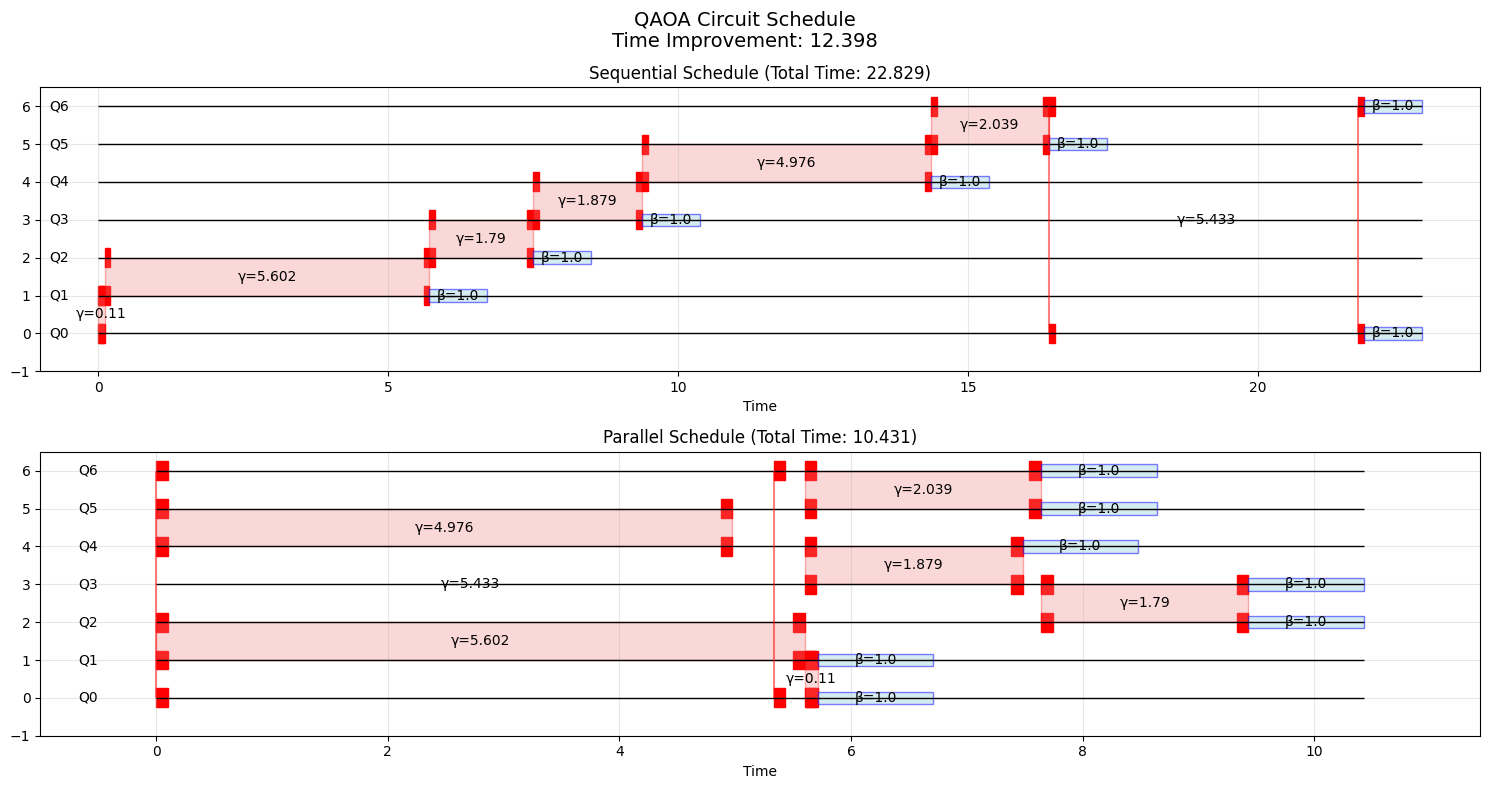


C7 Instance 3
------------------------------

Instance 3
Gate times:
  γ(Q0-Q1): 1.89
  γ(Q1-Q2): 1.55
  γ(Q2-Q3): 5.82
  γ(Q3-Q4): 5.60
  γ(Q4-Q5): 4.29
  γ(Q5-Q6): 3.56
  γ(Q6-Q0): 3.44

Scheduling results:
Total time before: 27.16
Total time after: 13.97
Time improvement: 13.18 (48.5%)

Scheduling layers:

Layer 1 (time = 5.82):
  Gate Q2-Q3: time = 5.82
  Gate Q4-Q5: time = 4.29
  Gate Q6-Q0: time = 3.44

Layer 2 (time = 5.60):
  Gate Q3-Q4: time = 5.60
  Gate Q5-Q6: time = 3.56
  Gate Q0-Q1: time = 1.89

Layer 3 (time = 1.55):
  Gate Q1-Q2: time = 1.55

Mixer layer (time = 1.00)


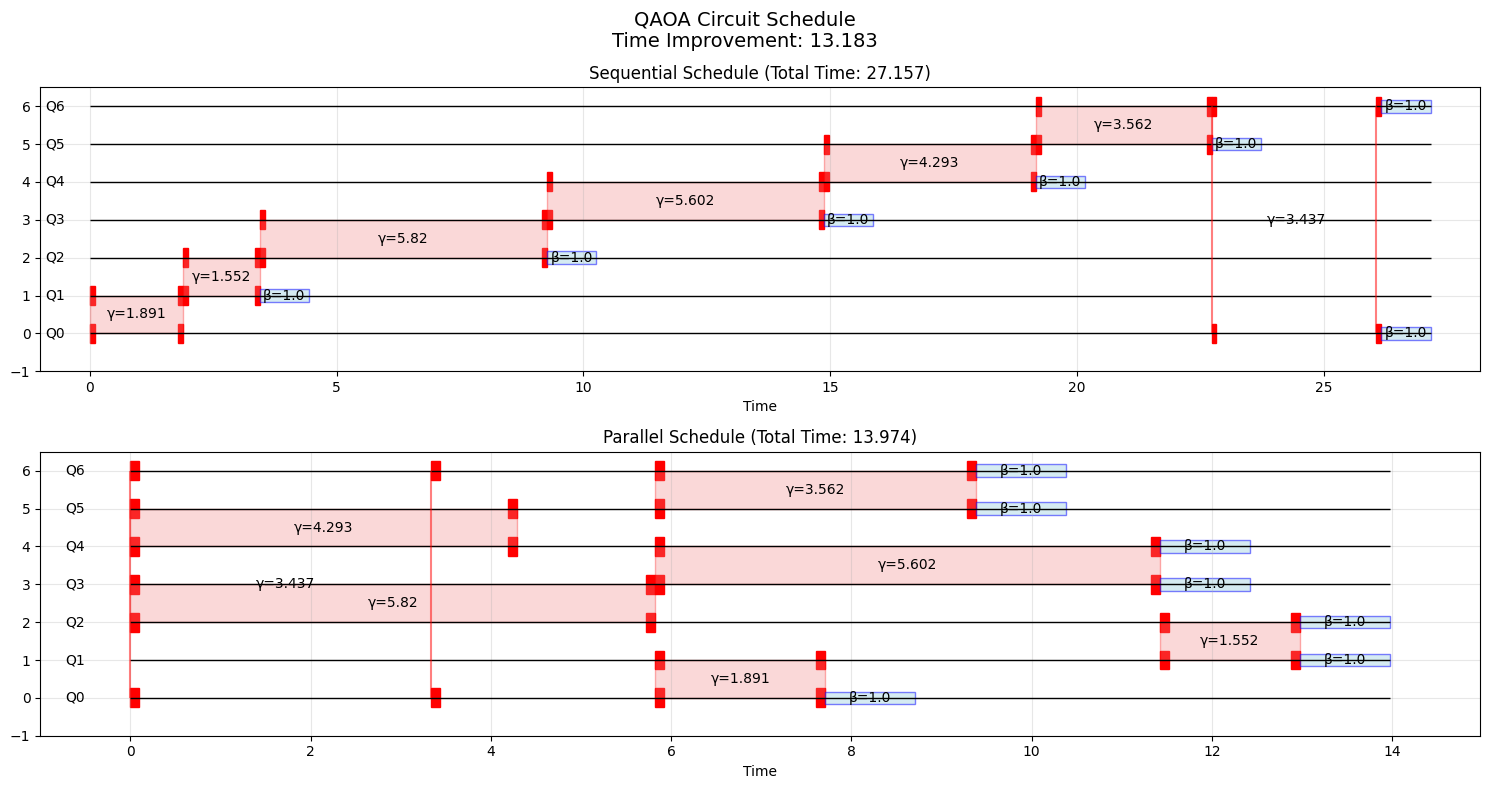


C7 Instance 4
------------------------------

Instance 4
Gate times:
  γ(Q0-Q1): 3.11
  γ(Q1-Q2): 1.43
  γ(Q2-Q3): 1.60
  γ(Q3-Q4): 2.49
  γ(Q4-Q5): 2.37
  γ(Q5-Q6): 6.26
  γ(Q6-Q0): 2.56

Scheduling results:
Total time before: 20.83
Total time after: 11.26
Time improvement: 9.57 (46.0%)

Scheduling layers:

Layer 1 (time = 6.26):
  Gate Q5-Q6: time = 6.26
  Gate Q0-Q1: time = 3.11
  Gate Q3-Q4: time = 2.49

Layer 2 (time = 2.56):
  Gate Q6-Q0: time = 2.56
  Gate Q4-Q5: time = 2.37
  Gate Q2-Q3: time = 1.60

Layer 3 (time = 1.43):
  Gate Q1-Q2: time = 1.43

Mixer layer (time = 1.00)


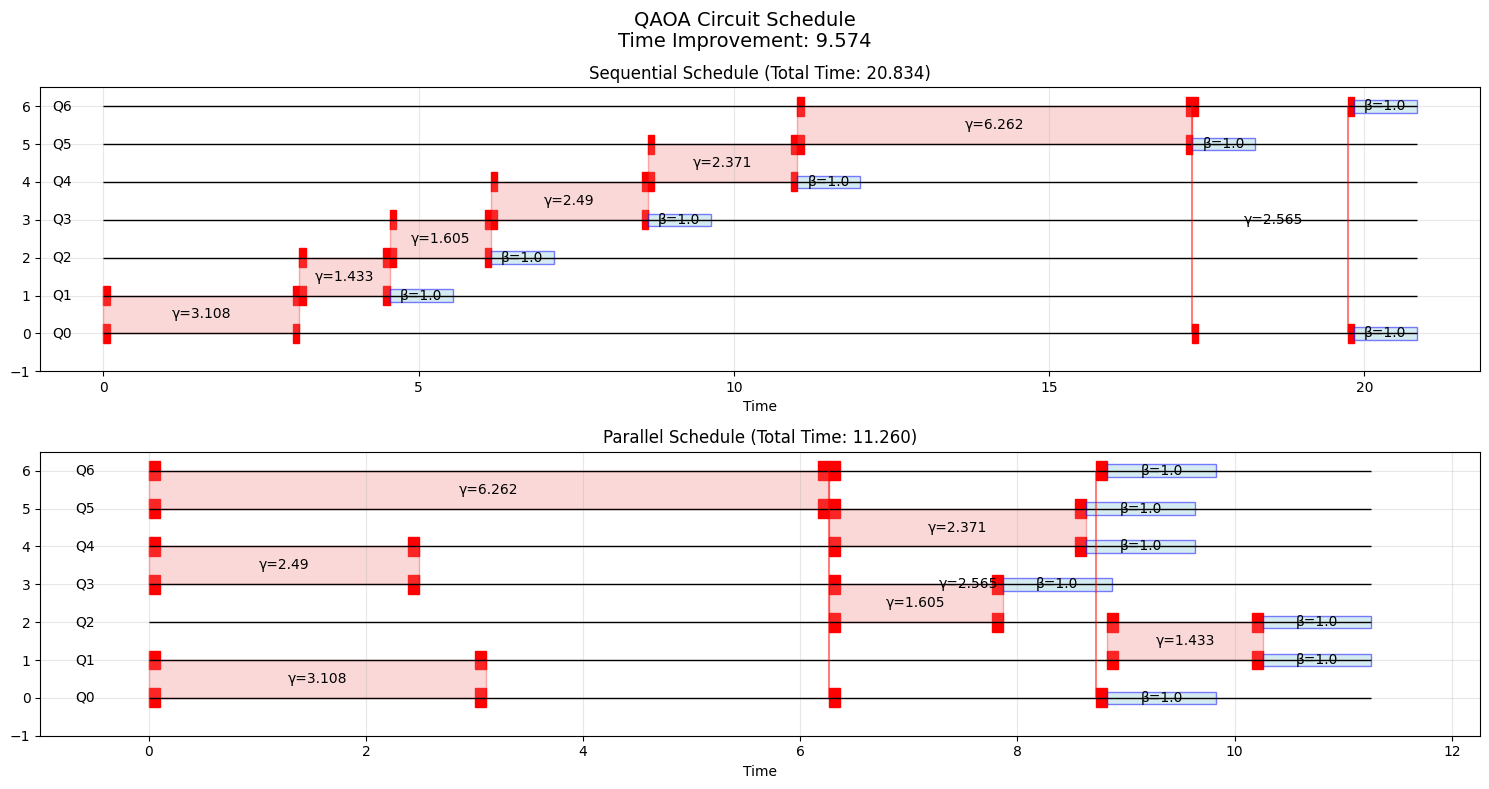


C7 Instance 5
------------------------------

Instance 5
Gate times:
  γ(Q0-Q1): 4.25
  γ(Q1-Q2): 0.28
  γ(Q2-Q3): 2.16
  γ(Q3-Q4): 4.05
  γ(Q4-Q5): 1.79
  γ(Q5-Q6): 5.96
  γ(Q6-Q0): 0.99

Scheduling results:
Total time before: 20.47
Total time after: 9.40
Time improvement: 11.07 (54.1%)

Scheduling layers:

Layer 1 (time = 5.96):
  Gate Q5-Q6: time = 5.96
  Gate Q0-Q1: time = 4.25
  Gate Q3-Q4: time = 4.05

Layer 2 (time = 2.16):
  Gate Q2-Q3: time = 2.16
  Gate Q4-Q5: time = 1.79
  Gate Q6-Q0: time = 0.99

Layer 3 (time = 0.28):
  Gate Q1-Q2: time = 0.28

Mixer layer (time = 1.00)


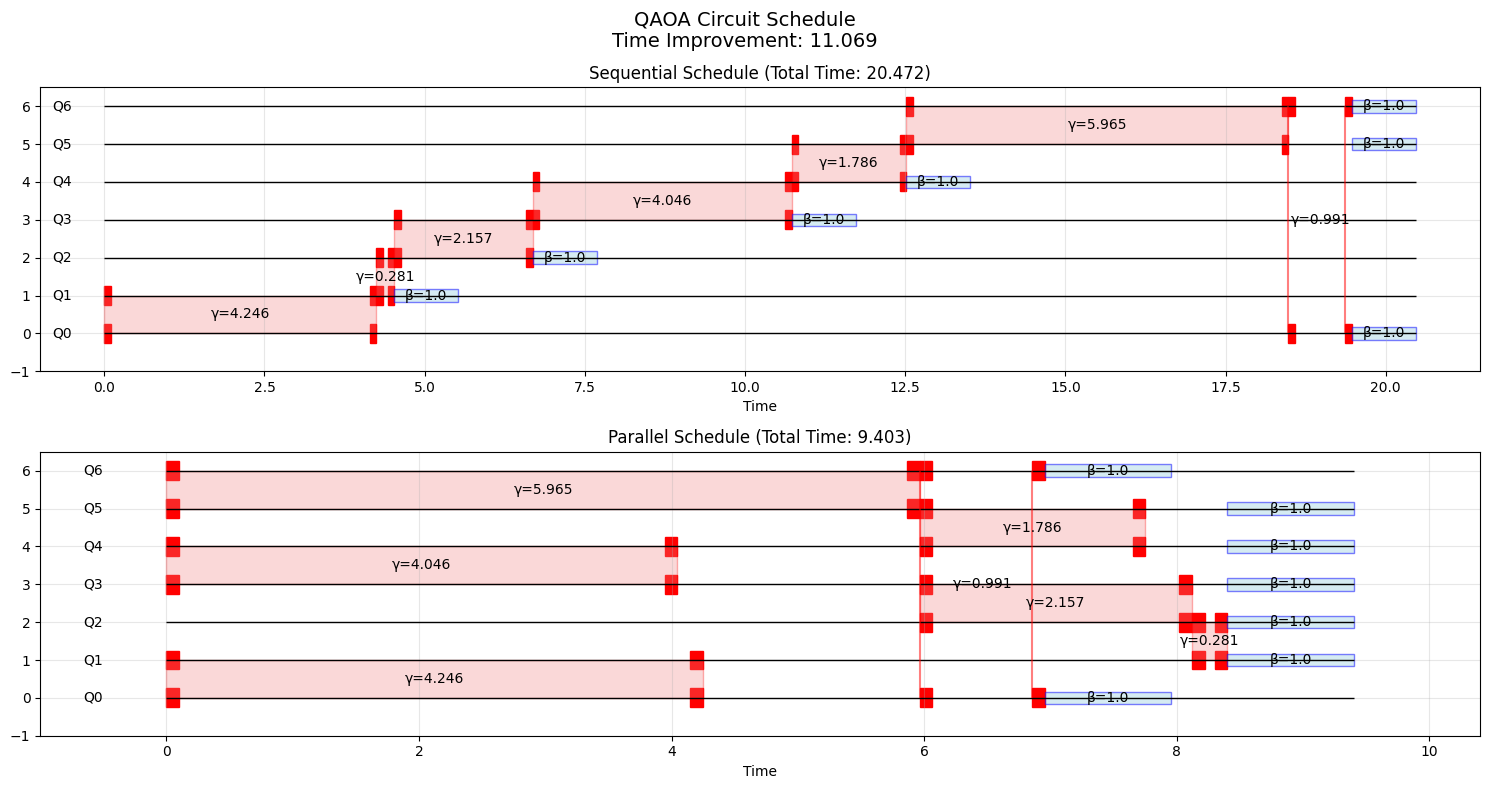


Analysis for C5:
Average improvement: 32.0%
Best improvement: 37.0%
Worst improvement: 27.9%
Average number of layers: 3.0
Layer distribution: (array([3]), array([5]))

Analysis for C7:
Average improvement: 51.8%
Best improvement: 55.9%
Worst improvement: 46.0%
Average number of layers: 3.0
Layer distribution: (array([3]), array([5]))

C5 vs C7 Comparison:
C5 average improvement: 32.0%
C7 average improvement: 51.8%

C5 layer statistics:
Min: 3, Max: 3, Average: 3.0

C7 layer statistics:
Min: 3, Max: 3, Average: 3.0


In [13]:
n_instances = 5
base_seed = 42

# C5 examples
print("\nC5 Examples")
print("=" * 50)
c5_results = []
for i in range(n_instances):
    print(f"\nC5 Instance {i+1}")
    print("-" * 30)
    circuit = create_random_circuit(n_qubits=5, seed=base_seed + i)
    result = run_example(circuit, i + 1)
    c5_results.append(result)

# C7 examples
print("\nC7 Examples")
print("=" * 50)
c7_results = []
for i in range(n_instances):
    print(f"\nC7 Instance {i+1}")
    print("-" * 30)
    circuit = create_random_circuit(n_qubits=7, seed=base_seed + n_instances + i)
    result = run_example(circuit, i + 1)
    c7_results.append(result)

# Analyze results
analyze_results(c5_results, "C5")
analyze_results(c7_results, "C7")

# Compare C5 vs C7
print("\nC5 vs C7 Comparison:")
print("=" * 50)
c5_improvements = [np.round(r.improvement / r.total_time_before, 3) for r in c5_results]
c7_improvements = [np.round(r.improvement / r.total_time_before, 3) for r in c7_results]

print(f"C5 average improvement: {np.mean(c5_improvements):.1%}")
print(f"C7 average improvement: {np.mean(c7_improvements):.1%}")

c5_layers = [len(r.cost_layers) for r in c5_results]
c7_layers = [len(r.cost_layers) for r in c7_results]

print(f"\nC5 layer statistics:")
print(
    f"Min: {min(c5_layers)}, Max: {max(c5_layers)}, Average: {np.mean(c5_layers):.1f}"
)
print(f"\nC7 layer statistics:")
print(
    f"Min: {min(c7_layers)}, Max: {max(c7_layers)}, Average: {np.mean(c7_layers):.1f}"
)